In [1]:
import numpy as np
from math import sin, cos, sqrt, acos, pi
import numpy as np
import scipy.linalg
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

In [2]:
def setgrid(nz, zmax, zfac):
    # construct regularly or geometrically spaced 1D grid
    # z(n)-z(1) = 2*z(1)*(zfac**(n-1)-1)/(zfac-1)
    # choice of z(1) and z(2) is compatible with conductionQ
  
    z = np.zeros(nz+1)
  
    if zfac>1.:
        dz = zmax/(3.+2.*zfac*(zfac**(nz-2)-1.)/(zfac-1.))
        z[1] = dz
        z[2] = 3*z[1]
        for i in range(3,nz+1):
            z[i] = (1.+zfac)*z[i-1] - zfac*z[i-2]
            # z[i] = z[i-1] + zfac*(z[i-1]-z[i-2]) # equivalent
    else:
        dz = zmax/nz
        for i in range(1,nz+1):
            z[i] = (i-0.5)*dz  

    return z



def heatflux_from_temperature(nz, z, T, k):
    # calculates heat flux from temperature profile
    # like k, the heat flux H is defined mid-point

    H = np.zeros(nz+1)
    # H[1] = -k[1] * (T[1]-Tsurf) / z[1]
    H[1] = 0. # to avoid ill-defined value
    for j in range(2,nz+1):
        H[j] = -k[j] * (T[j]-T[j-1]) / (z[j]-z[j-1])

    return H

In [3]:
def cranknQ(nz, z, dt, Qn, Qnp1, T, ti, rhoc, emiss, Fgeotherm, Fsurf):
    
    """
    To calculate the diffusion of temperature into the ground and thermal emission at the surface with variable thermal properties on irregular grid using Crank-Nicolson method

    Eqn: rhoc*T_t = (k*T_z)_z
    BC (z=0): Q(t) + kT_z = em*sig*T^4
    BC (z=L): heat flux = Fgeotherm

    nz = number of grid points (not counting the surface)
    dt = time step
    Qn,Qnp1 = net solar insolation at time steps n and n+1 [W/m^2]
    T = vertical temperature profile [K]  (in- and output)
    T[0] = surface temperature [K]  (in- and output)
    ti = thermal inertia [J m^-2 K^-1 s^-1/2]  
    VECTOR rhoc = rho*c VECTOR where rho=density [kg/m^3] and c=specific heat [J K^-1 kg^-1]
    ti and rhoc are not allowed to vary in the layers immediately adjacent to the surface or the bottom
    emiss = emissivity
    Fgeotherm def cranknQ(nz, z, dt, Qn, Qnp1, T, ti, rhoc, emiss, Fgeotherm, Fsurf):
    
    """
    To calculate the diffusion of temperature into the ground and thermal emission at the surface with variable thermal properties on irregular grid using Crank-Nicolson method

    Eqn: rhoc*T_t = (k*T_z)_z
    BC (z=0): Q(t) + kT_z = em*sig*T^4
    BC (z=L): heat flux = Fgeotherm

    nz = number of grid points (not counting the surface)
    dt = time step
    Qn,Qnp1 = net solar insolation at time steps n and n+1 [W/m^2]
    T = vertical temperature profile [K]  (in- and output)
    T[0] = surface temperature [K]  (in- and output)
    ti = thermal inertia [J m^-2 K^-1 s^-1/2]  
    VECTOR rhoc = rho*c VECTOR where rho=density [kg/m^3] and c=specific heat [J K^-1 kg^-1]
    ti and rhoc are not allowed to vary in the layers immediately adjacent to the surface or the bottom
    emiss = emissivity
    Fgeotherm = geothermal heat flux at bottom boundary [W/m^2]
    Fsurf = heat flux at surface [W/m^2]  (output)

    Grid: surface is at z=0
         z[0]=0, z[2]=3*z[1], i.e., the top layer has half the width
         T[1] is at z[1]; ...; T[i] is at z[i]
         k[i], rhoc[i], ti[i] are midway between z[i-1] and z[i]
         
    Variable thermal properties and irregular grid
    speed optimization, Volterra predictor 1
    """
    
    sigSB = 5.6704e-8

    # set some constants
    k = np.empty(nz+1)
    k = ti[:] ** 2 / rhoc[:]  # thermal conductivity
    alpha = np.empty(nz+1)
    gamma = np.empty(nz+1)

    dz = 2 * z[1]
    beta = dt / (rhoc[1] + rhoc[2]) / dz**2
    alpha[1] = beta * k[2]
    gamma[1] = beta * k[1]

    buf2 = dt * 2.0 / (rhoc[2:-1] + rhoc[3:]) / (z[3:] - z[1:-2])
    alpha[2:-1] = k[3:] * buf2 / (z[3:] - z[2:-1])
    gamma[2:-1] = k[2:-1] * buf2 / (z[2:-1] - z[1:-2])

    alpha[nz] = 0.0  
    gamma[nz] = dt * k[nz] / (2 * rhoc[nz]) / (z[nz]-z[nz-1])**2

    # for i in range(2,nz):  # 2 ... nz-1
    #    buf = dt / (z[i+1]-z[i-1])
    #    alpha[i] = 2*k[i+1]*buf/(rhoc[i]+rhoc[i+1])/(z[i+1]-z[i])
    #    gamma[i] = 2*k[i]*buf/(rhoc[i]+rhoc[i+1])/(z[i]-z[i-1])

    k1dz = k[1] / dz

    # elements of tridiagonal matrix
    # special matrix for solve_banded
    D = np.zeros((3, nz))
    D[0, 1:] = -alpha[1:-1]  # coefficient 'c'
    D[1, :] = 1.0 + alpha[1:] + gamma[1:]  # coefficient 'b'
    D[2, :-1] = -gamma[2:]  # coefficient 'a'
    # b[1] has to be reset at every timestep
    D[1,-1] = 1.0 + 2*gamma[nz]
    D[2,-2] = -2*gamma[nz]

    # Volterra predictor (optional)
    Fsurf = - k[1] * ( T[1]-T[0] ) / z[1]  # heat flux
    SEB = -Fsurf -emiss*sigSB*T[0]**4 + (2*Qnp1 + Qn)/3.
    pref = np.sqrt(4*dt/np.pi)
    # Tpred = T[0] + pref / ti[1] * SEB  ! 1st order
    Tpred = T[0] + SEB / ( ti[1]/pref + 8./3.*emiss*sigSB*T[0]**3 )
    Tr = (T[0]+Tpred)/2.  # better reference temperature
    
    # Emission
    #Tr = T[0]  # 'reference' temperature
    arad = -3.0 * emiss * sigSB * Tr**4
    brad = 2.0 * emiss * sigSB * Tr**3
    ann = (Qn - arad) / (k1dz + brad)
    annp1 = (Qnp1 - arad) / (k1dz + brad)
    bn = (k1dz - brad) / (k1dz + brad)
    b1 = 1.0 + alpha[1] + gamma[1] - gamma[1] * bn  # b[1]

    # Set RHS
    r = np.empty(nz+1)
    r[1] = (
        gamma[1] * (annp1 + ann)
        + (1.0 - alpha[1] - gamma[1] + gamma[1] * bn) * T[1]
        + alpha[1] * T[2]
    )
    # for i in range(2,nz): # 2...nz-1
    #    r[i] = gamma[i]*T[i-1] + (1.-alpha[i]-gamma[i])*T[i]+ alpha[i]*T[i+1]
    r[2:-1] = (
        gamma[2:-1] * T[1:-2]
        + (1.0 - alpha[2:-1] - gamma[2:-1]) * T[2:-1]
        + alpha[2:-1] * T[3:]
    )
    r[nz] = (
        2*gamma[nz] * T[nz-1]
        + (1.0 - 2*gamma[nz]) * T[nz]
        + 2 * dt / rhoc[nz] * Fgeotherm / (z[nz] - z[nz-1])
    )
    
    D[1, 0] = b1  # coefficient b[1]
    
    # Solve for T at n+1
    T[1:] = scipy.linalg.solve_banded((1, 1), D, r[1:])
    T[0] = 0.5 * (annp1 + bn * T[1] + T[1])  # (T0+T1)/2
    
    Fsurf = -k[1] * (T[1] - T[0]) / z[1]  # heat flux into surface




def conductionQ(nz, z, dt, Qn, Qnp1, T, ti, rhoc, emiss, Fgeotherm, Fsurf):
    """
    conductionQ:  wrapper for cranknQ, which improves stability.
    Arguments and restrictions are the same as for subroutine cranknQ above.
    created wrapper using flux smoothing 1/2024
    """

    Ni = 5  # number of sub-steps for flux smoothing

    Told = np.copy(T)
    
    cranknQ(nz,z,dt,Qn,Qnp1,T,ti,rhoc,emiss,Fgeotherm,Fsurf)
    
    # artificial flux smoothing
    if T[0] > 1.2*Told[0] or T[0] < 0.8*Told[0] :
        T[:] = Told[:]
        avFsurf = 0.
        for j in range(1,Ni+1):  # 1,...,Ni
            Qartiold = ( (Ni-j+1)*Qn + (j-1)*Qnp1 ) / Ni
            Qarti    = ( (Ni-j)*Qn + j*Qnp1 ) / Ni
            cranknQ(nz,z,dt/Ni,Qartiold,Qarti,T,ti,rhoc,emiss,Fgeotherm,Fsurf)
            avFsurf += Fsurf
        
        Fsurf = avFsurf/Ni= geothermal heat flux at bottom boundary [W/m^2]
    Fsurf = heat flux at surface [W/m^2]  (output)

    Grid: surface is at z=0
         z[0]=0, z[2]=3*z[1], i.e., the top layer has half the width
         T[1] is at z[1]; ...; T[i] is at z[i]
         k[i], rhoc[i], ti[i] are midway between z[i-1] and z[i]
         
    Variable thermal properties and irregular grid
    speed optimization, Volterra predictor 1
    """
    
    sigSB = 5.6704e-8

    # set some constants
    k = np.empty(nz+1)
    k = ti[:] ** 2 / rhoc[:]  # thermal conductivity
    alpha = np.empty(nz+1)
    gamma = np.empty(nz+1)

    dz = 2 * z[1]
    beta = dt / (rhoc[1] + rhoc[2]) / dz**2
    alpha[1] = beta * k[2]
    gamma[1] = beta * k[1]

    buf2 = dt * 2.0 / (rhoc[2:-1] + rhoc[3:]) / (z[3:] - z[1:-2])
    alpha[2:-1] = k[3:] * buf2 / (z[3:] - z[2:-1])
    gamma[2:-1] = k[2:-1] * buf2 / (z[2:-1] - z[1:-2])

    alpha[nz] = 0.0  
    gamma[nz] = dt * k[nz] / (2 * rhoc[nz]) / (z[nz]-z[nz-1])**2

    # for i in range(2,nz):  # 2 ... nz-1
    #    buf = dt / (z[i+1]-z[i-1])
    #    alpha[i] = 2*k[i+1]*buf/(rhoc[i]+rhoc[i+1])/(z[i+1]-z[i])
    #    gamma[i] = 2*k[i]*buf/(rhoc[i]+rhoc[i+1])/(z[i]-z[i-1])

    k1dz = k[1] / dz

    # elements of tridiagonal matrix
    # special matrix for solve_banded
    D = np.zeros((3, nz))
    D[0, 1:] = -alpha[1:-1]  # coefficient 'c'
    D[1, :] = 1.0 + alpha[1:] + gamma[1:]  # coefficient 'b'
    D[2, :-1] = -gamma[2:]  # coefficient 'a'
    # b[1] has to be reset at every timestep
    D[1,-1] = 1.0 + 2*gamma[nz]
    D[2,-2] = -2*gamma[nz]

    # Volterra predictor (optional)
    Fsurf = - k[1] * ( T[1]-T[0] ) / z[1]  # heat flux
    SEB = -Fsurf -emiss*sigSB*T[0]**4 + (2*Qnp1 + Qn)/3.
    pref = np.sqrt(4*dt/np.pi)
    # Tpred = T[0] + pref / ti[1] * SEB  ! 1st order
    Tpred = T[0] + SEB / ( ti[1]/pref + 8./3.*emiss*sigSB*T[0]**3 )
    Tr = (T[0]+Tpred)/2.  # better reference temperature
    
    # Emission
    #Tr = T[0]  # 'reference' temperature
    arad = -3.0 * emiss * sigSB * Tr**4
    brad = 2.0 * emiss * sigSB * Tr**3
    ann = (Qn - arad) / (k1dz + brad)
    annp1 = (Qnp1 - arad) / (k1dz + brad)
    bn = (k1dz - brad) / (k1dz + brad)
    b1 = 1.0 + alpha[1] + gamma[1] - gamma[1] * bn  # b[1]

    # Set RHS
    r = np.empty(nz+1)
    r[1] = (
        gamma[1] * (annp1 + ann)
        + (1.0 - alpha[1] - gamma[1] + gamma[1] * bn) * T[1]
        + alpha[1] * T[2]
    )
    # for i in range(2,nz): # 2...nz-1
    #    r[i] = gamma[i]*T[i-1] + (1.-alpha[i]-gamma[i])*T[i]+ alpha[i]*T[i+1]
    r[2:-1] = (
        gamma[2:-1] * T[1:-2]
        + (1.0 - alpha[2:-1] - gamma[2:-1]) * T[2:-1]
        + alpha[2:-1] * T[3:]
    )
    r[nz] = (
        2*gamma[nz] * T[nz-1]
        + (1.0 - 2*gamma[nz]) * T[nz]
        + 2 * dt / rhoc[nz] * Fgeotherm / (z[nz] - z[nz-1])
    )
    
    D[1, 0] = b1  # coefficient b[1]
    
    # Solve for T at n+1
    T[1:] = scipy.linalg.solve_banded((1, 1), D, r[1:])
    T[0] = 0.5 * (annp1 + bn * T[1] + T[1])  # (T0+T1)/2
    
    Fsurf = -k[1] * (T[1] - T[0]) / z[1]  # heat flux into surface




def conductionQ(nz, z, dt, Qn, Qnp1, T, ti, rhoc, emiss, Fgeotherm, Fsurf):
    """
    conductionQ:  wrapper for cranknQ, which improves stability.
    Arguments and restrictions are the same as for subroutine cranknQ above.
    created wrapper using flux smoothing 1/2024
    """

    Ni = 5  # number of sub-steps for flux smoothing

    Told = np.copy(T)
    
    cranknQ(nz,z,dt,Qn,Qnp1,T,ti,rhoc,emiss,Fgeotherm,Fsurf)
    
    # artificial flux smoothing
    if T[0] > 1.2*Told[0] or T[0] < 0.8*Told[0] :
        T[:] = Told[:]
        avFsurf = 0.
        for j in range(1,Ni+1):  # 1,...,Ni
            Qartiold = ( (Ni-j+1)*Qn + (j-1)*Qnp1 ) / Ni
            Qarti    = ( (Ni-j)*Qn + j*Qnp1 ) / Ni
            cranknQ(nz,z,dt/Ni,Qartiold,Qarti,T,ti,rhoc,emiss,Fgeotherm,Fsurf)
            avFsurf += Fsurf
        
        Fsurf = avFsurf/Ni

In [4]:
def flux_noatm(R,decl,latitude,HA,SlopeAngle,azFac):

    '''

    To calculate incoming solar flux without atmosphere
    R: distance from sun (AU)
    decl: planetocentric solar declination (radians)
    latitude: (radians)
    HA: hour angle (radians from noon, clockwise)
    SlopeAngle: >0, (radians) 
    azFac: azimuth of topographic gradient (radians east of north) azFac=0 is south-facing  

    '''
    
    So=1365.  # solar constant [W/m^2]
  
    c1 = cos(latitude)*cos(decl)
    s1 = sin(latitude)*sin(decl)
    # beta = 90 minus incidence angle for horizontal surface
    # beta = elevation of sun above (horizontal) horizon 
    sinbeta = c1*cos(HA) + s1
  
    cosbeta = sqrt(1-sinbeta**2)
    # hour angle -> azimuth
    buf = ( sin(decl)-sin(latitude)*sinbeta ) / (cos(latitude)*cosbeta)
    # buf can be NaN if cosbeta = 0
    if buf>+1.:
        buf=+1.0  # roundoff
    if buf<-1.:
        buf=-1.0  # roundoff
    azSun = acos(buf)
    if sin(HA)>=0:
        azSun = 2*pi-azSun

    # theta = 90 minus incidence angle for sloped surface
    sintheta = cos(SlopeAngle)*sinbeta - \
        sin(SlopeAngle)*cosbeta*cos(azSun-azFac)
    if cosbeta==0.:   # sun in zenith
        sintheta = cos(SlopeAngle)*sinbeta
    if sintheta<0.:
        sintheta = 0. # horizon
    if sinbeta<0.:
        sintheta=0.   # horizontal horizon at infinity
  
    flux_noatm = sintheta*So/(R**2)
  
    return flux_noatm

In [5]:
if __name__ == '__main__':
   
    sigSB = 5.6704e-8
    Period = 88775.244*670 # [seconds]
    NSTEPS = 50000
    emiss = 1.
    Fgeo = 0.2  # [W/m^2]

    STEPSPERSOL = 120
    dt = Period / STEPSPERSOL
    thIn = 120.  # thermal inertia
    albedo = 0.2
    latitude = 5.  # [degree]

    nz = 60; zmax = 2.5; zfac = 1.05

    # rhoc = thIn * np.sqrt(Period/pi)  # skin depth = 1
    rhocv = np.full(nz+1, 1200.*800. )  # (density) * (heat capacity)
    delta = thIn/rhocv[1] * np.sqrt(Period/np.pi)
    print('Skin depth= ',delta)
    ti = np.full(nz+1, thIn)

    #T = np.zeros(nz+1)
    #Tmean = np.zeros(nz+1)
    
    Rau = 1.52
    Decl = 0.
  
    print('Time step=',dt)
    print('zmax=',zmax)
    print('Thermal inertia=',thIn,' Period=',Period)
    print('Heat Flux at bottom boundary=',-Fgeo)
    
    # Initialize
    fout1 = open('Tsurface',"w")  # surface temperature
    fout2 = open('Tprofile',"w")  # temperature profile

    T = np.full( nz+1, 210. )
    Tmean = np.zeros_like( T )
    z = setgrid(nz,zmax,zfac)
    np.savetxt('z', z[1:], fmt='%g', newline=" ")
    
    latitude = np.deg2rad(latitude)

    time = 0.
    #fout1.write('%12.6f %9.3f %9.3f\n' % (0.,T[0],T[nz]) )
    #np.savetxt(fout2, np.column_stack(T[:]), fmt=" %7.2f"*(nz+1))
    
    Fmean = 0.
    HA = 0.
    Qn = (1-albedo) * flux_noatm(Rau,Decl,latitude,HA,0.,0.)
    Fsurf = 0.

    for n in range (0,NSTEPS+1):
        
        time = (n+1)*dt   #   time at n+1; 
        HA = 2 * np.pi * (time/Period % 1.) #  hour angle
        Qnp1 = (1-albedo) * flux_noatm(Rau,Decl,latitude,HA,0.,0.)
        conductionQ(nz,z,dt,Qn,Qnp1,T,ti,rhocv,emiss,Fgeo,Fsurf)
        Qn = Qnp1

        if n%3 == 0:
            fout1.write('%12.6f %9.3f %9.3f\n' % (time/Period,T[0],T[nz]) )

        if (n > NSTEPS-STEPSPERSOL):
            Fmean += Fmean
            Tmean = Tmean[:] + T[:]            
            if n%10 == 0:
                np.savetxt(fout2,np.column_stack(T[:]),fmt=" %7.2f"*(nz+1))
                
    # end of time loop
    
    Fmean = Fmean / STEPSPERSOL
    Tmean[:] = Tmean[:] / STEPSPERSOL

    fout1.close()
    fout2.close()
    
    

Skin depth=  0.5438991941167934
Time step= 495661.77900000004
zmax= 2.5
Thermal inertia= 120.0  Period= 59479413.480000004
Heat Flux at bottom boundary= -0.2


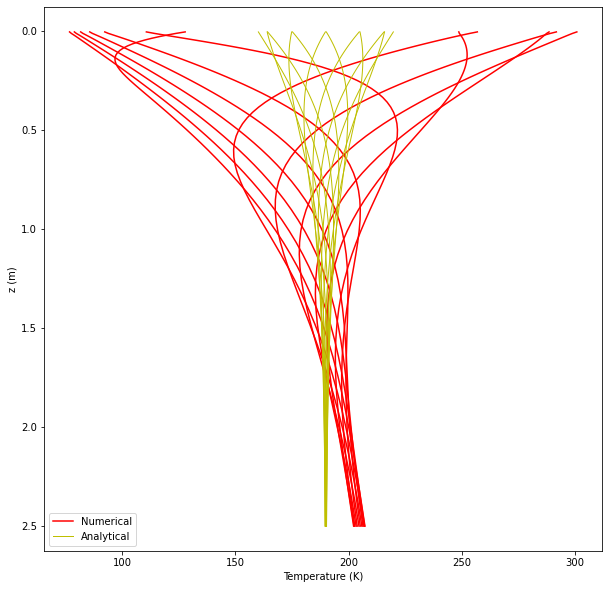

<Figure size 432x288 with 0 Axes>

In [6]:
wpth='./'

a = np.loadtxt(wpth + 'Tprofile')
T = a[:,1:]
z = np.loadtxt(wpth + 'z')


# plot profile
plt.figure(figsize=(10, 10))
plot(T[0,:],z,'r-',label='Numerical')
for i in range(1,12):
    plot(T[i,:],z,'r-')
        
xlabel('Temperature (K)')
ylabel('z (m)')
gca().invert_yaxis()


# compare with analytical solution for sinusoidal surface temperature oscillation and semi-infinite domain

Ta=30.; Tm=190.; P=670.*88775.244
rhoc = 1200*800; thIn=120
delta = thIn/rhoc * np.sqrt(P/np.pi)   # skin depth
w = 2*np.pi/P
dt = P/12
TT = np.zeros(len(z))

for i in range(0,12):
    t = i*dt
    TT = Tm + Ta * np.exp(-z/delta) * np.sin(z/delta-w*t)
    if i==0:
        plot(TT,z,'y-',linewidth=1,label='Analytical')
    else:
        plot(TT,z,'y-',linewidth=1)
        


legend()

show()
plt.savefig('Tprofile_crankQ.png',format='png')

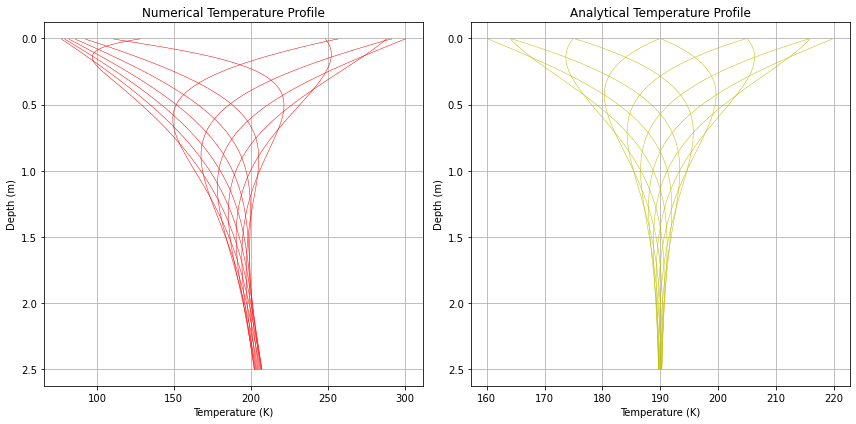

<Figure size 432x288 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load numerical temperature profiles and depth information
a = np.loadtxt('Tprofile')
T_numerical = a[:, 1:]
z = np.loadtxt('z')

# Plot numerical temperature profiles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot 1: Numerical solution
for i in range(12):
    plt.plot(T_numerical[i], z, 'r-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Numerical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

# Analytical solution parameters
Ta = 30.
Tm = 190.
P = 670. * 88775.244
rhoc = 1200 * 800
thIn = 120
delta = thIn / rhoc * np.sqrt(P / np.pi)  # Skin depth
w = 2 * np.pi / P
dt = P / 12

# Calculate and plot analytical temperature profile
TT_analytical = np.zeros(len(z))
plt.subplot(1, 2, 2)  # Subplot 2: Analytical solution
for i in range(12):
    t = i * dt
    TT_analytical = Tm + Ta * np.exp(-z / delta) * np.sin(z / delta - w * t)
    plt.plot(TT_analytical, z, 'y-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Analytical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('Tprofile_crankQ_sep.png',format='png')

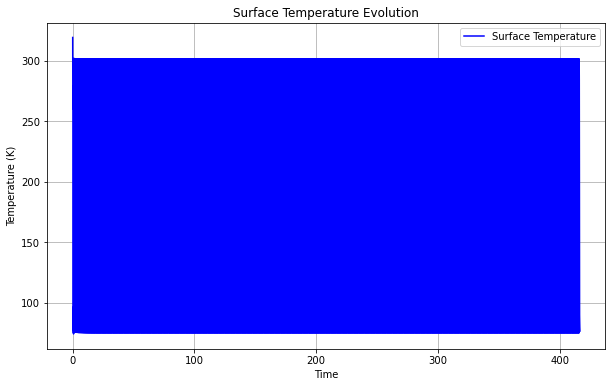

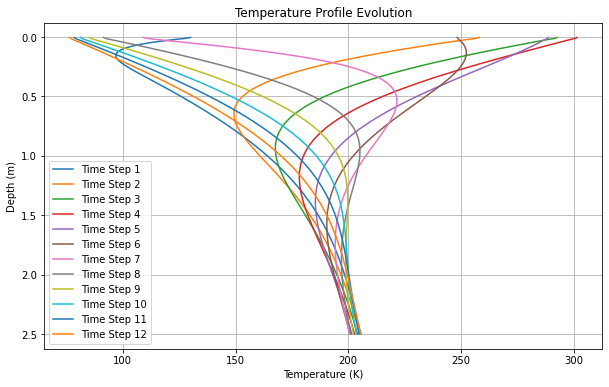

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load surface temperature data
surface_data = np.loadtxt('Tsurface')
time_surface = surface_data[:, 0]  # Time
surface_temp = surface_data[:, 1]  # Surface temperature

# Load temperature profile data
profile_data = np.loadtxt('Tprofile')
z = np.loadtxt('z')
time_profile = np.arange(len(profile_data))  # Assuming each row corresponds to a time step

# Plot surface temperature
plt.figure(figsize=(10, 6))
plt.plot(time_surface, surface_temp, 'b-', label='Surface Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Surface Temperature Evolution')
plt.legend()
plt.grid(True)
plt.show()

# Plot temperature profiles
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.plot(profile_data[i, :-1], z, label=f'Time Step {i+1}')  # Adjusted to match dimensions
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile Evolution')
plt.legend()
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.grid(True)
plt.show()
